I ran the following notebook in a docker container with the following commands:

```
docker run -it -v `pwd`:/space/ -p 8888:8888 -p 6006:6006 --name dl -w /space/ --rm utensil/dl:models_notop jupyter notebook --ip=0.0.0.0` to start.
```

In [ ]:
%%bash
pip2 install -U pip
pip2 install -U Pillow
pip2 install -U captcha
pip2 install -U tensorflow
pip2 install -U theano
pip2 install -U keras
pip2 install -U tflearn
pip2 install -U pandas
pip2 install -U scikit-learn
pip2 install -U h5py
pip2 install -U pydot-ng

In [1]:
# -*- coding: utf-8 -*-

""" Convolutional Neural Network for MNIST dataset classification task.
References:
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based
    learning applied to document recognition." Proceedings of the IEEE,
    86(11):2278-2324, November 1998.
Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
"""

from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import numpy as np
import tensorflow as tf

In [4]:
learn = tf.contrib.learn
tf.logging.set_verbosity(tf.logging.DEBUG)

In [4]:
mnist = learn.datasets.load_dataset('mnist')

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [6]:
data = mnist.train.images
labels = np.asarray(mnist.train.labels, dtype=np.int32)
test_data = mnist.test.images
test_labels = np.asarray(mnist.test.labels, dtype=np.int32)

In [7]:
max_examples = 10000
data = data[:max_examples]
labels = labels[:max_examples]

In [7]:
def display(i):
    img = test_data[i]
    plt.title('Example %d. Label: %d' % (i, test_labels[i]))
    plt.imshow(img.reshape((28,28)), cmap=plt.cm.gray_r)    

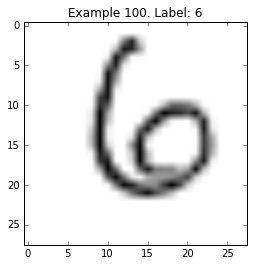

In [8]:
display(100)

In [4]:
# Data loading and preprocessing
import tflearn.datasets.mnist as mnist
X, Y, testX, testY = mnist.load_data(one_hot=True)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [5]:
max_examples = 10000
X = X.reshape([-1, 28, 28, 1])[:max_examples]
testX = testX.reshape([-1, 28, 28, 1])

In [10]:

# Building convolutional network
network = input_data(shape=[None, 28, 28, 1], name='input')
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = fully_connected(network, 128, activation='relu')
network = dropout(network, 0.8)
network = fully_connected(network, 256, activation='relu')
network = dropout(network, 0.8)
network = fully_connected(network, 10, activation='softmax')
network = regression(network, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target')

# Training
model = tflearn.DNN(network, tensorboard_verbose=3, tensorboard_dir='./logs/')
model.fit({'input': X}, {'target': Y}, n_epoch=1,
           validation_set=({'input': testX}, {'target': testY}),
           snapshot_step=100, show_metric=True, run_id='convnet_mnist')

Training Step: 157  | total loss: 0.22930
| Adam | epoch: 001 | loss: 0.22930 - acc: 0.9326 | val_loss: 0.13490 - val_acc: 0.9602 -- iter: 10000/10000
Training Step: 157  | total loss: 0.22930
| Adam | epoch: 001 | loss: 0.22930 - acc: 0.9326 | val_loss: 0.13490 - val_acc: 0.9602 -- iter: 10000/10000
--


In [6]:
from tflearn.layers.core import flatten

IMAGE_STD_HEIGHT = 28
IMAGE_STD_WIDTH = 28
RGB_COLOR_COUNT = 1
OPTIMIZER = tflearn.optimizers.AdaDelta(learning_rate=1.0, rho=0.95)
# , epsilon=1e-08, use_locking=False, name='AdaDelta')# 'adam' # 'adadelta'
# (lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)

# This is the same as keras default glorot_normal
INIT = tflearn.initializations.xavier(uniform=False) # , seed=None, dtype=tf.float32)
CLASS_COUNT = 10

def conv_2d_specialized(incoming, nb_filter, filter_size):
    return conv_2d(incoming, nb_filter, filter_size,
        padding='valid',
        activation='relu',
        weights_init=INIT) #, regularizer="L2")

def create_cnn_layers():
    shape = [None, IMAGE_STD_HEIGHT, IMAGE_STD_WIDTH, RGB_COLOR_COUNT]

    # input_layer = Input(name='input', shape=shape)
    input_layer = input_data(name='input', shape=shape)
    # h = Convolution2D(22, 5, 5, activation='relu', dim_ordering=dim_ordering)(input_layer)
    h = conv_2d_specialized(input_layer, 22, [5, 5])
    POOL_SIZE = [2, 2]
    # h = MaxPooling2D(pool_size=POOL_SIZE)(h)
    h = max_pool_2d(h, POOL_SIZE, padding='valid')
    h = local_response_normalization(h)
    # h = Convolution2D(44, 3, 3, activation='relu', dim_ordering=dim_ordering)(h)
    h = conv_2d_specialized(h, 44, [3, 3])
    # h = MaxPooling2D(pool_size=POOL_SIZE)(h)
    h = max_pool_2d(h, POOL_SIZE, padding='valid')
    h = local_response_normalization(h)
    # h = Dropout(0.25)(h)
    h = dropout(h, 1-0.25)
    # last_cnn_layer = Flatten()(h)
    last_cnn_layer = flatten(h)
    return input_layer, last_cnn_layer

def create_single_digit_model():
    input_layer, last_cnn_layer = create_cnn_layers()

    # h = Dense(256, activation='relu')(last_cnn_layer)
    h = fully_connected(last_cnn_layer, 256, activation='relu', weights_init=INIT)
    # h = Dropout(0.5)(h)
    h = dropout(h, 1-0.5)
    # output_layer = Dense(CLASS_COUNT, activation='softmax', name='out')(h)
    output_layer = fully_connected(h, CLASS_COUNT, activation='softmax', weights_init=INIT)
    network = regression(output_layer, optimizer=OPTIMIZER,
                     learning_rate=0.1,
                     loss='categorical_crossentropy', name='out')
    # model = Model(input_layer, output_layer)
    model = tflearn.DNN(network, tensorboard_verbose=3, tensorboard_dir='./logs/')
    return model

In [7]:
tf.logging.set_verbosity(tf.logging.ERROR)
model = create_single_digit_model()
model.fit({'input': X}, {'out': Y}, n_epoch=3,
           validation_set=({'input': testX}, {'out': testY}),
           snapshot_step=100, show_metric=True, run_id='conv4captcha_mnist')

Training Step: 471  | total loss: 0.18873
| AdaDelta | epoch: 003 | loss: 0.18873 - acc: 0.9393 | val_loss: 0.10362 - val_acc: 0.9705 -- iter: 10000/10000
Training Step: 471  | total loss: 0.18873
| AdaDelta | epoch: 003 | loss: 0.18873 - acc: 0.9393 | val_loss: 0.10362 - val_acc: 0.9705 -- iter: 10000/10000
--


In [9]:
sc = tf.get_variable_scope()

In [19]:
[v.name for v in tflearn.variables.get_all_variables()]

[u'is_training:0',
 u'Conv2D/W:0',
 u'Conv2D/b:0',
 u'Conv2D_1/W:0',
 u'Conv2D_1/b:0',
 u'FullyConnected/W:0',
 u'FullyConnected/b:0',
 u'FullyConnected_1/W:0',
 u'FullyConnected_1/b:0',
 u'Training_step:0',
 u'Global_Step:0',
 u'val_loss:0',
 u'val_acc:0',
 u'Accuracy/Mean/moving_avg:0',
 u'Accuracy/Mean/moving_avg/biased:0',
 u'Accuracy/Mean/moving_avg/local_step:0',
 u'AdaDelta/Crossentropy/Mean/moving_avg:0',
 u'AdaDelta/Crossentropy/Mean/moving_avg/biased:0',
 u'AdaDelta/Crossentropy/Mean/moving_avg/local_step:0',
 u'AdaDelta/Conv2D/W/AdaDelta:0',
 u'AdaDelta/Conv2D/W/AdaDelta_1:0',
 u'AdaDelta/Conv2D/b/AdaDelta:0',
 u'AdaDelta/Conv2D/b/AdaDelta_1:0',
 u'AdaDelta/Conv2D_1/W/AdaDelta:0',
 u'AdaDelta/Conv2D_1/W/AdaDelta_1:0',
 u'AdaDelta/Conv2D_1/b/AdaDelta:0',
 u'AdaDelta/Conv2D_1/b/AdaDelta_1:0',
 u'AdaDelta/FullyConnected/W/AdaDelta:0',
 u'AdaDelta/FullyConnected/W/AdaDelta_1:0',
 u'AdaDelta/FullyConnected/b/AdaDelta:0',
 u'AdaDelta/FullyConnected/b/AdaDelta_1:0',
 u'AdaDelta/Ful

In [20]:
[v.name for v in tflearn.variables.get_all_trainable_variable()]

[u'Conv2D/W:0',
 u'Conv2D/b:0',
 u'Conv2D_1/W:0',
 u'Conv2D_1/b:0',
 u'FullyConnected/W:0',
 u'FullyConnected/b:0',
 u'FullyConnected_1/W:0',
 u'FullyConnected_1/b:0']